# **Downloading UAVSAR Data & Making GIS-Ready Products**

0. [Running the Notebook](#s1)
1. [Download UAVSAR Data](#s2)
2. [Generate a HDR File](#s3)
3. [Read in data and plot](#s4)
4. [Crop and export to geotiff](#s5)

<a name="s1"></a>
## Running the Notebook
- This Notebook has both "text" and "code" cells. The text cells have text descriptions about running the notebooks and data interpretation.
- Code cells are a light gray and a "play" button appears in the upper left corner when your mouse is hovered over the cell.
- To run the content in the code cells, **select the play button** in the upper left corner of each code cell or **press shift-enter**.

### Python Packages:
This routine uses the following python libraries. Some are already included in the Google Colab environment and others are installed in the cell below before imported. Downloading new python packages to this environment may take a few minutes to complete.

In [1]:
# !pip install rasterio --quiet        # Install python package "rasterio" into Google Colab environment

# Scripts and functions needed from GitHub repos
# To build HDR files
!git clone https://bitbucket.org/nathanmthomas/bucket-of-rs-and-gis-scripts/src/master/BuildUAVSARhdr.py

# To appy Enhanced Lee Speckle Filter
!git clone https://github.com/NaiaraSPinto/VegMapper.git

# To generate geotiffs and apply incidence angle masking
!wget https://raw.githubusercontent.com/anniepeacock/DANSAR/devel/utils/functions.py

Cloning into 'BuildUAVSARhdr.py'...
remote: Enumerating objects: 229, done.
remote: Counting objects: 100% (229/229), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 229 (delta 120), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (229/229), 50.10 KiB | 916.00 KiB/s, done.
Resolving deltas: 100% (120/120), done.
Cloning into 'VegMapper'...
remote: Enumerating objects: 1618, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 1618 (delta 55), reused 84 (delta 26), pack-reused 1480 (from 1)
Receiving objects: 100% (1618/1618), 154.26 MiB | 33.60 MiB/s, done.
Resolving deltas: 100% (870/870), done.
--2024-11-11 08:52:31--  https://raw.githubusercontent.com/anniepeacock/DANSAR/devel/utils/functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent

In [3]:
import rasterio as rio               # Reading and writing raster formats
import numpy as np                   # Numeric and mathematic functions
import matplotlib.pyplot as plt      # Plotting, making graphs
import getpass                       # Discreet way to enter username and password
import os
from osgeo import gdal
from skimage import filters          # For otsu thresholding
import math
import geopandas as gpd
from matplotlib.patches import Patch          # Creates and plots visualization i.e. legends or figures 
from rasterio.plot import plotting_extent     # Creates an object to plot raster and vector data together
import requests
from osgeo import gdal
from rasterio.plot import show_hist
from rasterio.mask import mask as rio_mask
from shapely.geometry import mapping
from rasterio.plot import show

from rasterio.transform import from_origin
from affine import Affine
from rasterio.features import rasterize

# Read in functions from functions.py script
from functions import * #download_files, process_grd_files, process_inc_files, mask_and_save, convert_db

# Read in enhanced lee filter from VegMapper
import sys
path_to_module = './VegMapper/vegmapper/core/'
sys.path.append(path_to_module)
from filter import enhanced_lee

Can run below if GDAL is causing issues in Google Colab: https://github.com/googlecolab/colabtools/issues/3375

In [ ]:
# !%%shell
# !yes | add-apt-repository ppa:ubuntugis/ppa
# !apt-get update
# !apt-get install gdal-bin libgdal-dev
# !C_INCLUDE_PATH=/usr/include/gdal CPLUS_INCLUDE_PATH=/usr/include/gdal python -m pip install GDAL=="$(gdal-config --version)"

# 1. Download UAVSAR Data

* An Earthdata account is required to download the UAVSAR data to this notebook environment. Create an account here, if needed: https://urs.earthdata.nasa.gov//users/new

* Download fire perimeters from NFIC: https://data-nifc.opendata.arcgis.com/

In [43]:
## If using Google Colab, need to upload fire perimeters to session

In [10]:
username = getpass.getpass(prompt='Earthdata username:')
password = getpass.getpass(prompt='Earthdata password:')

Earthdata username: ········
Earthdata password: ········


Now, download the UAVSAR data and its corresponding annotation file using wget and your Earthdata username and password. The annotation file (.ann) is required to generate a HDR (.hdr) file. This hdr file stores the georeferencing information of an associated raw raster file and is needed to make the UAVSAR GRD files (.grd) GIS-readable.


Browse for UAVSAR data of interest here: https://uavsar.jpl.nasa.gov/cgi-bin/data.pl

* To download here, replace the links below with the new data of interest
* Some of the links from the product pages weren't working with the download function, so used wget


For the 2024 Bridge & Line fires:


In [11]:
# UAVSAR GRDs and corresponding annotation files (needed to make HDR files and make GRDs GIS-compatible)
uavsar_urls = [
    "https://uavsar.jpl.nasa.gov/Release2w/sanber_10802_24080_017_241017_L090_CX_01/sanber_10802_24080_017_241017_L090_CX_01.ann",
    "https://downloaduav.jpl.nasa.gov/Release2w/sanber_10802_24080_017_241017_L090_CX_01/sanber_10802_24080_017_241017_L090HVHV_CX_01.grd",
    "https://downloaduav.jpl.nasa.gov/Release2w/sanber_10802_24080_017_241017_L090_CX_01/sanber_10802_24080_017_241017_L090HHHH_CX_01.grd",
    "https://downloaduav.jpl.nasa.gov/Release2w/sanber_10802_24080_017_241017_L090_CX_01/sanber_10802_24080_017_241017_L090VVVV_CX_01.grd",

    "https://uavsar.jpl.nasa.gov/Release3a/sanber_10800_24080_019_241017_L090_CX_01/sanber_10800_24080_019_241017_L090_CX_01.ann",
    "https://downloaduav.jpl.nasa.gov/Release3a/sanber_10800_24080_019_241017_L090_CX_01/sanber_10800_24080_019_241017_L090HVHV_CX_01.grd",
    "https://downloaduav.jpl.nasa.gov/Release3a/sanber_10800_24080_019_241017_L090_CX_01/sanber_10800_24080_019_241017_L090HHHH_CX_01.grd",
    "https://downloaduav.jpl.nasa.gov/Release3a/sanber_10800_24080_019_241017_L090_CX_01/sanber_10800_24080_019_241017_L090VVVV_CX_01.grd",

    # # "https://uavsar.asf.alaska.edu/UA_sanber_10802_24067_003_240918_L090_CX_01/sanber_10802_24067_003_240918_L090HVHV_CX_01.grd", ## not working
    "https://uavsar.asf.alaska.edu/UA_sanber_10802_24067_003_240918_L090_CX_01/sanber_10802_24067_003_240918_L090_CX_01.ann",

    "https://uavsar.asf.alaska.edu/UA_sanber_10802_23001_009_230605_L090_CX_01/sanber_10802_23001_009_230605_L090_CX_01.ann",
    # "https://uavsar.asf.alaska.edu/UA_sanber_10802_23001_009_230605_L090_CX_01/sanber_10802_23001_009_230605_L090HVHV_CX_01.grd", ## not working

    "https://uavsar.asf.alaska.edu/UA_sanber_10800_24067_005_240918_L090_CX_01/sanber_10800_24067_005_240918_L090_CX_01.ann",
    # "https://uavsar.asf.alaska.edu/UA_sanber_10800_24067_005_240918_L090_CX_01/sanber_10800_24067_005_240918_L090HVHV_CX_01.grd", ## not working

    "https://uavsar.asf.alaska.edu/UA_sanber_10800_23001_004_230605_L090_CX_01/sanber_10800_23001_004_230605_L090_CX_01.ann",
    # "https://uavsar.asf.alaska.edu/UA_sanber_10800_23001_004_230605_L090_CX_01/sanber_10800_23001_004_230605_L090HVHV_CX_01.grd" ## not working
]

destination_directory = "./"

download_files(uavsar_urls, destination_directory, username, password)

# can also download one at a time with wget:
# !wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_SanAnd_08525_14158_003_141023_L090_CX_01/SanAnd_08525_14158_003_141023_L090HVHV_CX_01.grd

Downloaded: sanber_10802_24080_017_241017_L090_CX_01.ann
Downloaded: sanber_10802_24080_017_241017_L090HVHV_CX_01.grd
Downloaded: sanber_10802_24080_017_241017_L090HHHH_CX_01.grd
Downloaded: sanber_10802_24080_017_241017_L090VVVV_CX_01.grd
Downloaded: sanber_10800_24080_019_241017_L090_CX_01.ann
Downloaded: sanber_10800_24080_019_241017_L090HVHV_CX_01.grd
Downloaded: sanber_10800_24080_019_241017_L090HHHH_CX_01.grd
Downloaded: sanber_10800_24080_019_241017_L090VVVV_CX_01.grd
Downloaded: sanber_10802_24067_003_240918_L090_CX_01.ann
Downloaded: sanber_10802_23001_009_230605_L090_CX_01.ann
Downloaded: sanber_10800_24067_005_240918_L090_CX_01.ann
Downloaded: sanber_10800_23001_004_230605_L090_CX_01.ann


## Tried wget for the grd links that weren't working

In [12]:
!wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_sanber_10800_23001_004_230605_L090_CX_01/sanber_10800_23001_004_230605_L090HVHV_CX_01.grd --quiet
!wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_sanber_10800_23001_004_230605_L090_CX_01/sanber_10800_23001_004_230605_L090HHHH_CX_01.grd --quiet
!wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_sanber_10800_23001_004_230605_L090_CX_01/sanber_10800_23001_004_230605_L090VVVV_CX_01.grd --quiet

In [13]:
!wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_sanber_10800_24067_005_240918_L090_CX_01/sanber_10800_24067_005_240918_L090HVHV_CX_01.grd --quiet
!wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_sanber_10800_24067_005_240918_L090_CX_01/sanber_10800_24067_005_240918_L090HHHH_CX_01.grd --quiet
!wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_sanber_10800_24067_005_240918_L090_CX_01/sanber_10800_24067_005_240918_L090VVVV_CX_01.grd --quiet

In [14]:
!wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_sanber_10802_23001_009_230605_L090_CX_01/sanber_10802_23001_009_230605_L090HVHV_CX_01.grd --quiet
!wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_sanber_10802_23001_009_230605_L090_CX_01/sanber_10802_23001_009_230605_L090HHHH_CX_01.grd --quiet
!wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_sanber_10802_23001_009_230605_L090_CX_01/sanber_10802_23001_009_230605_L090VVVV_CX_01.grd --quiet

In [15]:
!wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_sanber_10802_24067_003_240918_L090_CX_01/sanber_10802_24067_003_240918_L090HVHV_CX_01.grd --quiet
!wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_sanber_10802_24067_003_240918_L090_CX_01/sanber_10802_24067_003_240918_L090HHHH_CX_01.grd --quiet
!wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_sanber_10802_24067_003_240918_L090_CX_01/sanber_10802_24067_003_240918_L090VVVV_CX_01.grd --quiet

In [16]:
# # Download incidence angle files
!wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_sanber_10802_23001_009_230605_L090_CX_01/sanber_10802_23001_009_230605_L090_CX_01.inc --quiet
!wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_sanber_10800_24067_005_240918_L090_CX_01/sanber_10800_24067_005_240918_L090_CX_01.inc --quiet

# 2. Generate HDR files

Generate HDR files for each of the GRDs, so they can be GIS-compatible and converted to geotiffs.

In [17]:
!python3 "./BuildUAVSARhdr.py/BuildUAVSARhdr.py" -h

UAVSAR.py is written by Nathan Thomas (nmthomas28@gmail.com, @DrNASApants)  formerly of the Aberystwyth University Earth Observation and Ecosystems Dynamics Laboratory (@AU_EarthObs) as part of a visiting research program at NASA JPL. Ammended to process UAVSAR InSAR pair data by Yang Zheng (April 2015).
Use '-h' for help and required input parameters

usage: BuildUAVSARhdr.py [-h] [-i INPUT] [-r UAVSAR] [-p POLARIZATION]

options:
  -h, --help            show this help message and exit
  -i INPUT, --input INPUT
                        Specify the input UAVSAR ann file
  -r UAVSAR, --uavsar UAVSAR
                        Specify the input UAVSAR radar file
  -p POLARIZATION, --polarization POLARIZATION
                        Specify the input UAVSAR polarization in UPPERCASE
                        (i.e HHHV, HHHH, VVVV, AMP1, AMP2, COR, UNW, HGT, INT)


In [21]:
def run_hdr_script(directory, polarization):
    file_data = []

    # Find GRD and annotation files
    for filename in os.listdir(directory):
        if filename.endswith('.grd'):
            grd_file = filename
            annotation_file = filename.replace(f'_L090{polarization}_', '_L090_').replace('.grd', '.ann')
            file_data.append((grd_file, annotation_file))
        elif filename.endswith('.inc'):
            grd_file = filename
            annotation_file = filename.replace(f'_L090{polarization}_', '_L090_').replace('.inc', '.ann')
            file_data.append((grd_file, annotation_file))

    # Run HDR script for each file
    for grd_file, annotation_file in file_data:
        !python3 "./BuildUAVSARhdr.py/BuildUAVSARhdr.py" -i {annotation_file} -r {grd_file} -p {polarization}

# Run HDR script for HVHV polarization
run_hdr_script('./', 'HVHV')

# Run HDR script for HHHH polarization
run_hdr_script('./', 'HHHH')

# Run HDR script for incidence angle files (assuming .inc files)
run_hdr_script('./', 'VVVV')  # You can put whichever polarization, using HVHV as a placeholder here

UAVSAR.py is written by Nathan Thomas (nmthomas28@gmail.com, @DrNASApants)  formerly of the Aberystwyth University Earth Observation and Ecosystems Dynamics Laboratory (@AU_EarthObs) as part of a visiting research program at NASA JPL. Ammended to process UAVSAR InSAR pair data by Yang Zheng (April 2015).
Use '-h' for help and required input parameters

Traceback (most recent call last):
  File "/Users/peacock/Downloads/2024_Fire/./BuildUAVSARhdr.py/BuildUAVSARhdr.py", line 127, in <module>
    main()
  File "/Users/peacock/Downloads/2024_Fire/./BuildUAVSARhdr.py/BuildUAVSARhdr.py", line 123, in main
    genHDRfromTXT(args)
  File "/Users/peacock/Downloads/2024_Fire/./BuildUAVSARhdr.py/BuildUAVSARhdr.py", line 31, in genHDRfromTXT
    annFile = open(file, 'r')
FileNotFoundError: [Errno 2] No such file or directory: 'sanber_10802_24080_017_241017_L090VVVV_CX_01.ann'
UAVSAR.py is written by Nathan Thomas (nmthomas28@gmail.com, @DrNASApants)  formerly of the Aberystwyth University Earth Ob

# 3. Crop the data and export subset to geotiff

In [117]:
# Define input directory and output directory
input_directory = './' # Directory containing GRD and INC files
output_directory = './'  # Directory to save processed files

# # Bridge Fire: Define extent and projection details
# upper_left_x = 421212.4298829008
# upper_left_y = 3810000
# lower_right_x = 449827.43423470017
# lower_right_y = 3776177.065960707

# Line Fire: Define extent and projection details
upper_left_x = 480000
upper_left_y = 3787000
lower_right_x = 509354
lower_right_y = 3771000

window = (upper_left_x, upper_left_y, lower_right_x, lower_right_y)

projection = 'EPSG:26911' # reprojecting here to be in meters. Landsat data will be reprojected in meters.

In [118]:
# Process GRD files
process_grd_files(input_directory, output_directory, window, projection)

In [119]:
# Process incidence angle files
process_inc_files(input_directory, output_directory, window, projection)

# 5. Incidence Angle Corrections/Masking

Converting sigma0 to gamma0 should remove some range/incidence angle dependency.

gamma0 = sigma0 / cos(incidence angle)

In [120]:
mask_and_save(input_directory, output_directory)

./sanber_10802_24067_003_240918_L090HHHH_CX_01_masked.tif
./sanber_10802_23001_009_230605_L090HVHV_CX_01_masked.tif
./sanber_10802_24080_017_241017_L090HVHV_CX_01_masked.tif
./sanber_10800_24080_019_241017_L090VVVV_CX_01_masked.tif
./sanber_10800_24067_005_240918_L090HHHH_CX_01_masked.tif
./sanber_10800_24067_005_240918_L090HVHV_CX_01_masked.tif
./sanber_10800_23001_004_230605_L090VVVV_CX_01_masked.tif
./sanber_10802_23001_009_230605_L090HHHH_CX_01_masked.tif
./sanber_10802_24080_017_241017_L090HHHH_CX_01_masked.tif
./sanber_10802_24067_003_240918_L090HVHV_CX_01_masked.tif
./sanber_10802_23001_009_230605_L090VVVV_CX_01_masked.tif
./sanber_10802_24080_017_241017_L090VVVV_CX_01_masked.tif
./sanber_10800_23001_004_230605_L090HHHH_CX_01_masked.tif
./sanber_10800_24080_019_241017_L090HVHV_CX_01_masked.tif
./sanber_10800_23001_004_230605_L090HVHV_CX_01_masked.tif
./sanber_10800_24067_005_240918_L090VVVV_CX_01_masked.tif
./sanber_10800_24080_019_241017_L090HHHH_CX_01_masked.tif
./sanber_10802

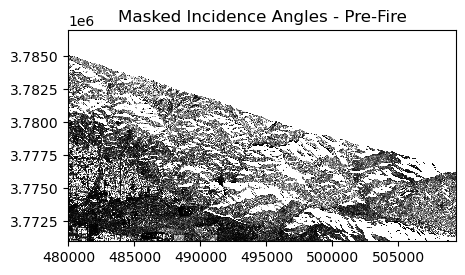

In [121]:
prefire = rio.open('./sanber_10800_23001_004_230605_L090HVHV_CX_01_masked.tif')
prefire = prefire.read(1)
fig, axs = plt.subplots(figsize=(5,5))
plt.title("Masked Incidence Angles - Pre-Fire")
plt.imshow(prefire, vmin=0, vmax=0.1, cmap="Greys_r", interpolation='nearest', extent=[upper_left_x, lower_right_x, lower_right_y, upper_left_y], origin='lower', )

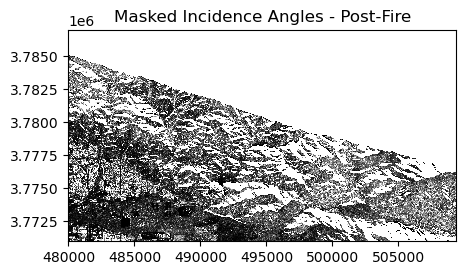

In [122]:
postfire = rio.open('./sanber_10800_24067_005_240918_L090HVHV_CX_01_masked.tif')
postfire = postfire.read(1)
fig, axs = plt.subplots(figsize=(5,5))
plt.title("Masked Incidence Angles - Post-Fire")
plt.imshow(postfire, vmin=0, vmax=0.1, cmap="Greys_r", interpolation='nearest', extent=[upper_left_x, lower_right_x, lower_right_y, upper_left_y], origin='lower', )

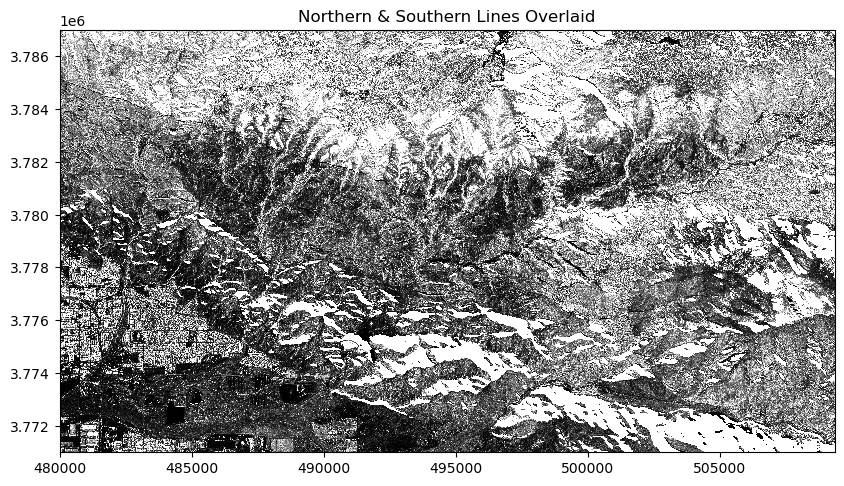

In [123]:
other_line = rio.open('./sanber_10802_24080_017_241017_L090HVHV_CX_01_masked.tif')
other_line = other_line.read(1)
fig, axs = plt.subplots(figsize=(10,10))
plt.title("Northern & Southern Lines Overlaid")
plt.imshow(other_line, vmin=0, vmax=0.1, cmap="Greys_r", interpolation='nearest', extent=[upper_left_x, lower_right_x, lower_right_y, upper_left_y], origin='lower', )
plt.imshow(postfire, vmin=0, vmax=0.1, cmap="Greys_r", interpolation='nearest', extent=[upper_left_x, lower_right_x, lower_right_y, upper_left_y], origin='lower', )

### Merge HV Arrays

In [124]:
## Pre-Fire
# Open the two input rasters using rasterio
with rio.open('./sanber_10800_23001_004_230605_L090HVHV_CX_01_masked.tif') as src1:
    arr1 = src1.read(1, masked=True)
    meta1 = src1.meta

with rio.open('./sanber_10802_23001_009_230605_L090HVHV_CX_01_masked.tif') as src2:
    arr2 = src2.read(1, masked=True)
    meta2 = src2.meta

print("Shape of arr1:", arr1.shape)
print("Shape of arr2:", arr2.shape)

# Or, if arr2 is larger, you can clip it similarly:
arr2_clipped = arr2[:arr1.shape[0], :arr1.shape[1]]

# Merge the two arrays using numpy's maximum function to take the maximum value at each pixel
merged_arr_prefire = np.nanmax((arr1, arr2_clipped), axis=0)

## Post-Fire
# Open the two input rasters using rasterio
with rio.open('./sanber_10800_24080_019_241017_L090HVHV_CX_01_masked.tif') as src1:
    arr1 = src1.read(1, masked=True)
    meta1 = src1.meta

with rio.open('./sanber_10802_24080_017_241017_L090HVHV_CX_01_masked.tif') as src2:
    arr2 = src2.read(1, masked=True)
    meta2 = src2.meta

# Or, if arr2 is larger, you can clip it similarly:
arr2_clipped = arr2[:arr1.shape[0], :arr1.shape[1]]

# Merge the two arrays using numpy's maximum function to take the maximum value at each pixel
merged_arr_postfire = np.nanmax((arr1, arr2_clipped), axis=0)

Shape of arr1: (2837, 5206)
Shape of arr2: (2837, 5206)


/var/folders/t5/5vl5_8fs71g6vbpzy81bwts40000gq/T/ipykernel_27403/1302299153.py:18: RuntimeWarning: All-NaN axis encountered
  merged_arr_prefire = np.nanmax((arr1, arr2_clipped), axis=0)
/var/folders/t5/5vl5_8fs71g6vbpzy81bwts40000gq/T/ipykernel_27403/1302299153.py:34: RuntimeWarning: All-NaN axis encountered
  merged_arr_postfire = np.nanmax((arr1, arr2_clipped), axis=0)


### Merge HH Arrays

In [125]:
## Pre-Fire
# Open the two input rasters using rasterio
with rio.open('./sanber_10800_23001_004_230605_L090HHHH_CX_01_masked.tif') as src1:
    arr1 = src1.read(1, masked=True)
    meta1 = src1.meta

with rio.open('./sanber_10802_23001_009_230605_L090HHHH_CX_01_masked.tif') as src2:
    arr2 = src2.read(1, masked=True)
    meta2 = src2.meta

print("Shape of arr1:", arr1.shape)
print("Shape of arr2:", arr2.shape)

# Or, if arr2 is larger, you can clip it similarly:
arr2_clipped = arr2[:arr1.shape[0], :arr1.shape[1]]

# Merge the two arrays using numpy's maximum function to take the maximum value at each pixel
merged_arr_prefire_HH = np.nanmax((arr1, arr2_clipped), axis=0)

## Post-Fire
# Open the two input rasters using rasterio
with rio.open('./sanber_10800_24080_019_241017_L090HHHH_CX_01_masked.tif') as src1:
    arr1 = src1.read(1, masked=True)
    meta1 = src1.meta

with rio.open('./sanber_10802_24080_017_241017_L090HHHH_CX_01_masked.tif') as src2:
    arr2 = src2.read(1, masked=True)
    meta2 = src2.meta

# Or, if arr2 is larger, you can clip it similarly:
arr2_clipped = arr2[:arr1.shape[0], :arr1.shape[1]]

# Merge the two arrays using numpy's maximum function to take the maximum value at each pixel
merged_arr_postfire_HH = np.nanmax((arr1, arr2_clipped), axis=0)

Shape of arr1: (2837, 5206)
Shape of arr2: (2837, 5206)


/var/folders/t5/5vl5_8fs71g6vbpzy81bwts40000gq/T/ipykernel_27403/265380830.py:18: RuntimeWarning: All-NaN axis encountered
  merged_arr_prefire_HH = np.nanmax((arr1, arr2_clipped), axis=0)
/var/folders/t5/5vl5_8fs71g6vbpzy81bwts40000gq/T/ipykernel_27403/265380830.py:34: RuntimeWarning: All-NaN axis encountered
  merged_arr_postfire_HH = np.nanmax((arr1, arr2_clipped), axis=0)


### Merge VV Arrays

In [126]:
## Pre-Fire
# Open the two input rasters using rasterio
with rio.open('./sanber_10800_23001_004_230605_L090VVVV_CX_01_masked.tif') as src1:
    arr1 = src1.read(1, masked=True)
    meta1 = src1.meta

with rio.open('./sanber_10802_23001_009_230605_L090VVVV_CX_01_masked.tif') as src2:
    arr2 = src2.read(1, masked=True)
    meta2 = src2.meta

print("Shape of arr1:", arr1.shape)
print("Shape of arr2:", arr2.shape)

# Or, if arr2 is larger, you can clip it similarly:
arr2_clipped = arr2[:arr1.shape[0], :arr1.shape[1]]

# Merge the two arrays using numpy's maximum function to take the maximum value at each pixel
merged_arr_prefire_VV = np.nanmax((arr1, arr2_clipped), axis=0)

## Post-Fire
# Open the two input rasters using rasterio
with rio.open('./sanber_10800_24080_019_241017_L090VVVV_CX_01_masked.tif') as src1:
    arr1 = src1.read(1, masked=True)
    meta1 = src1.meta

with rio.open('./sanber_10802_24080_017_241017_L090VVVV_CX_01_masked.tif') as src2:
    arr2 = src2.read(1, masked=True)
    meta2 = src2.meta

# Or, if arr2 is larger, you can clip it similarly:
arr2_clipped = arr2[:arr1.shape[0], :arr1.shape[1]]

# Merge the two arrays using numpy's maximum function to take the maximum value at each pixel
merged_arr_postfire_VV = np.nanmax((arr1, arr2_clipped), axis=0)

Shape of arr1: (2837, 5206)
Shape of arr2: (2837, 5206)


/var/folders/t5/5vl5_8fs71g6vbpzy81bwts40000gq/T/ipykernel_27403/362394751.py:18: RuntimeWarning: All-NaN axis encountered
  merged_arr_prefire_VV = np.nanmax((arr1, arr2_clipped), axis=0)
/var/folders/t5/5vl5_8fs71g6vbpzy81bwts40000gq/T/ipykernel_27403/362394751.py:34: RuntimeWarning: All-NaN axis encountered
  merged_arr_postfire_VV = np.nanmax((arr1, arr2_clipped), axis=0)


In [127]:
# fig, axs = plt.subplots(figsize=(20,10))
# plt.title("Merged Post-Fire Lines")
# plt.imshow(merged_arr_postfire, vmin=0, vmax=0.1, cmap="Greys_r", interpolation='nearest', extent=[upper_left_x, lower_right_x, lower_right_y, upper_left_y], origin='lower')

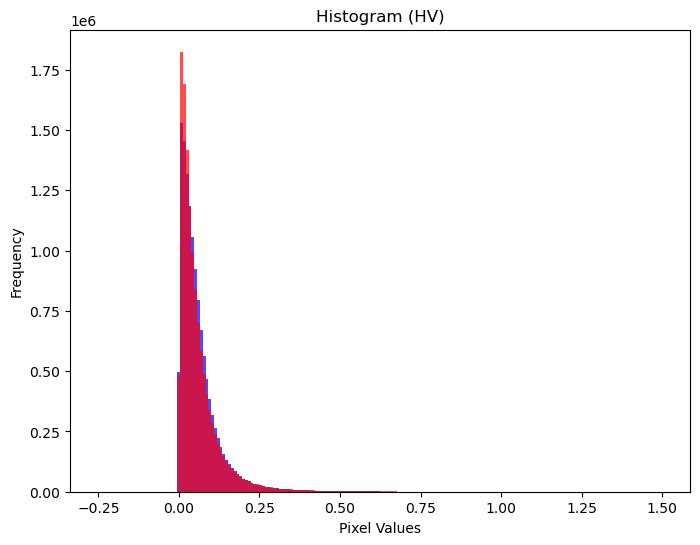

In [128]:
plt.figure(figsize=(8, 6))
plt.hist(merged_arr_prefire.flatten(), range = [-0.25, 1.5], bins=200, alpha=0.7, color='blue')
plt.hist(merged_arr_postfire.flatten(), range = [-0.25, 1.5], bins=200, alpha=0.7, color='red')
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.title('Histogram (HV)')
plt.show()

# Lee Filter

In [129]:
## HV
lee_prefire = enhanced_lee(merged_arr_prefire, 5, 1)
lee_postfire= enhanced_lee(merged_arr_postfire, 5, 1)
## HH
lee_prefire_HH = enhanced_lee(merged_arr_prefire_HH, 5, 1)
lee_postfire_HH = enhanced_lee(merged_arr_postfire_HH, 5, 1)
## VV
lee_prefire_VV = enhanced_lee(merged_arr_prefire_VV, 5, 1)
lee_postfire_VV = enhanced_lee(merged_arr_postfire_VV, 5, 1)

/Users/peacock/Downloads/2024_Fire/./VegMapper/vegmapper/core/filter.py:53: RuntimeWarning: invalid value encountered in divide
  ci = img_std / img_mean         # it's fine that img_mean could be zero here


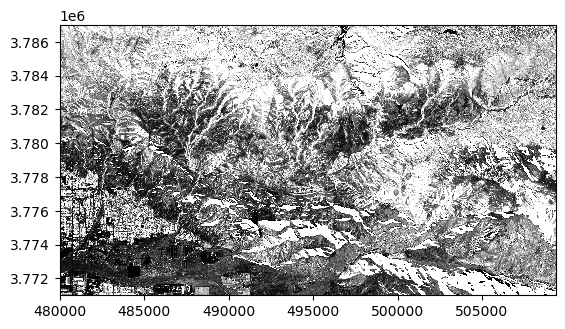

In [130]:
plt.imshow(lee_postfire, vmin=0, vmax=0.1, cmap="Greys_r", interpolation='nearest', extent=[upper_left_x, lower_right_x, lower_right_y, upper_left_y], origin='lower', )

In [131]:
## Log Ratios
HV_log = np.log(np.divide(lee_prefire, lee_postfire))
HH_log = np.log(np.divide(lee_prefire_HH, lee_postfire_HH))
VV_log = np.log(np.divide(lee_prefire_VV, lee_postfire_VV))

/var/folders/t5/5vl5_8fs71g6vbpzy81bwts40000gq/T/ipykernel_27403/3315766808.py:2: RuntimeWarning: divide by zero encountered in divide
  HV_log = np.log(np.divide(lee_prefire, lee_postfire))
/var/folders/t5/5vl5_8fs71g6vbpzy81bwts40000gq/T/ipykernel_27403/3315766808.py:2: RuntimeWarning: overflow encountered in divide
  HV_log = np.log(np.divide(lee_prefire, lee_postfire))
/var/folders/t5/5vl5_8fs71g6vbpzy81bwts40000gq/T/ipykernel_27403/3315766808.py:2: RuntimeWarning: invalid value encountered in divide
  HV_log = np.log(np.divide(lee_prefire, lee_postfire))
/var/folders/t5/5vl5_8fs71g6vbpzy81bwts40000gq/T/ipykernel_27403/3315766808.py:2: RuntimeWarning: divide by zero encountered in log
  HV_log = np.log(np.divide(lee_prefire, lee_postfire))
/var/folders/t5/5vl5_8fs71g6vbpzy81bwts40000gq/T/ipykernel_27403/3315766808.py:3: RuntimeWarning: divide by zero encountered in divide
  HH_log = np.log(np.divide(lee_prefire_HH, lee_postfire_HH))
/var/folders/t5/5vl5_8fs71g6vbpzy81bwts40000gq/T/

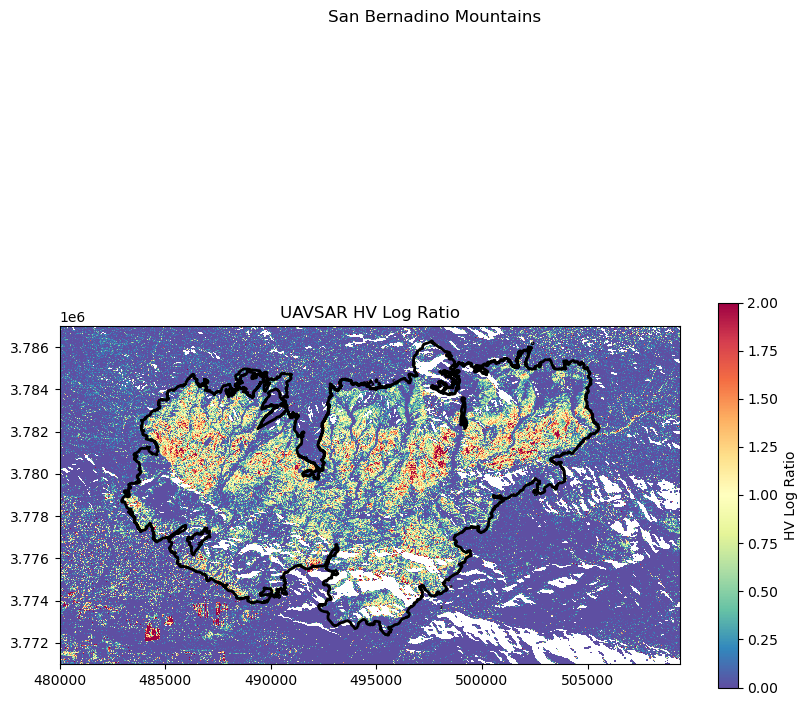

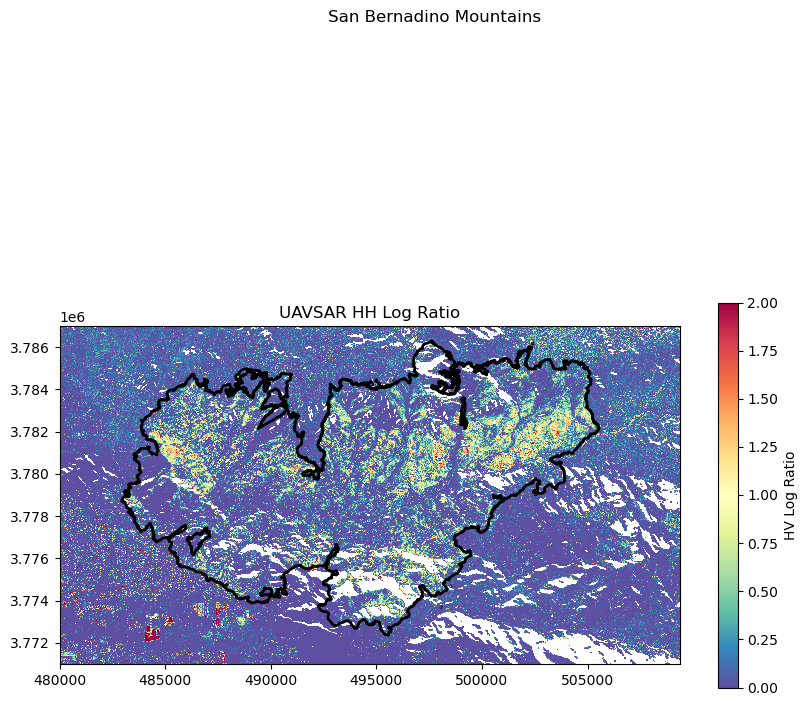

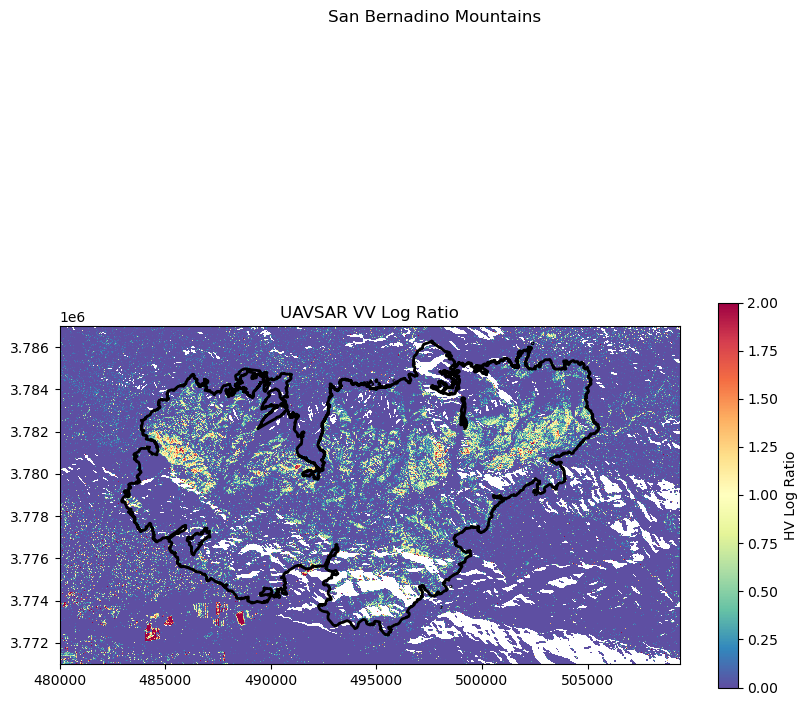

In [132]:
#@title Plot UAVSAR HV Log Ratio with Fire Perimeter
def plot_hv_log_dnbr(HV_log_ratio, geo_tiff_file, area_perimeter_file, area_name, radar_title):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    with rio.open(geo_tiff_file) as subset_src:  # getting reference extent
        subset_extent = plotting_extent(subset_src)
        trans = subset_src.transform

    area_perimeter = gpd.read_file(area_perimeter_file)
    area_perimeter = area_perimeter["geometry"]
    area_boundary = area_perimeter.to_crs(subset_src.crs)
    area_boundary.plot(edgecolor='black', facecolor='none', linewidth=2, ax=ax)

    # Add general map title
    fig.suptitle(area_name)

    # Map vis parameters
    cmap = "Spectral_r"
    vmin = 0
    vmax = 2
    args = dict(vmin=vmin, vmax=vmax, cmap=cmap, extent=subset_extent)

    # Plot HV Log Ratio
    plot = ax.imshow(HV_log_ratio.squeeze(), vmin=vmin, vmax=vmax, cmap=cmap, interpolation='nearest',extent=[upper_left_x, lower_right_x, lower_right_y, upper_left_y], origin='lower')
    ax.set_title(radar_title)
    cbar=fig.colorbar(plot, ax=ax, shrink=0.5)
    cbar.set_label('HV Log Ratio')

    plt.show()

# Function call
plot_hv_log_dnbr(HV_log, './sanber_10800_23001_004_230605_L090HVHV_CX_01_clipped.tif', 'line_fire.geojson', 'San Bernadino Mountains', 'UAVSAR HV Log Ratio')
plot_hv_log_dnbr(HH_log, './sanber_10800_23001_004_230605_L090HVHV_CX_01_clipped.tif', 'line_fire.geojson', 'San Bernadino Mountains', 'UAVSAR HH Log Ratio')
plot_hv_log_dnbr(VV_log, './sanber_10800_23001_004_230605_L090HVHV_CX_01_clipped.tif', 'line_fire.geojson', 'San Bernadino Mountains', 'UAVSAR VV Log Ratio')

In [133]:
# fig, axs = plt.subplots(figsize=(20,10))
# plt.title('HH Log Ratio')
# HH_log_plt = axs.imshow(HH_log, vmin=0, vmax=2, cmap="Spectral_r", interpolation="nearest", extent=[upper_left_x, lower_right_x, lower_right_y, upper_left_y], origin='lower', )
# fig.colorbar(HH_log_plt, ax=axs, shrink=0.5)

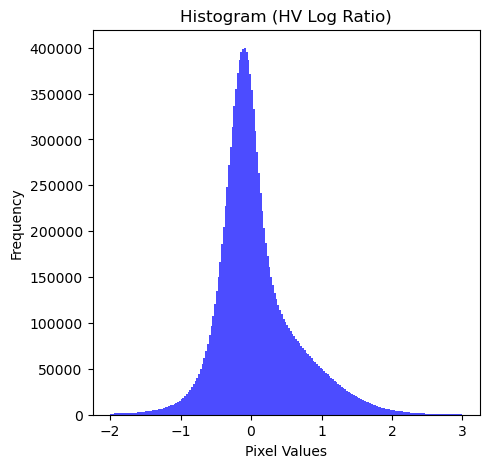

In [135]:
plt.figure(figsize=(5, 5))
plt.hist(HV_log.flatten(), range = [-2, 3],bins=200, alpha=0.7, color='blue')
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.title('Histogram (HV Log Ratio)')
plt.show()

#### Mask areas outside the mountains

## Save individual geotiffs

In [136]:
# reference geotiff
with rio.open("./sanber_10800_23001_004_230605_L090HVHV_CX_01_masked.tif") as src:
    transform = src.transform
    print("Affine Transform:", transform)
    crs = src.crs
    print("Coordinate Reference System:", crs)
    bounds = src.bounds
    print("Bounds:", bounds)
    resolution = src.res
    print("Resolution:", resolution)

# export HV_log ratio
with rio.open(
    "HV_log.tif",
    "w",
    driver="GTiff",
    height=HV_log.shape[0],
    width=HV_log.shape[1],
    count=1,
    dtype=HV_log.dtype,
    crs= crs,
    transform=transform
) as dst:
    dst.write(HV_log, 1)
# export HV pre-fire
with rio.open(
    "HV_prefire.tif",
    "w",
    driver="GTiff",
    height=lee_prefire.shape[0],
    width=lee_prefire.shape[1],
    count=1,
    dtype=lee_prefire.dtype,
    crs= crs,
    transform=transform
) as dst:
    dst.write(lee_prefire, 1)
# export HV post-fire
with rio.open(
    "HV_postfire.tif",
    "w",
    driver="GTiff",
    height=lee_postfire.shape[0],
    width=lee_postfire.shape[1],
    count=1,
    dtype=lee_postfire.dtype,
    crs= crs,
    transform=transform
) as dst:
    dst.write(lee_postfire_HH, 1)

# export HH pre-fire
with rio.open(
    "HH_prefire.tif",
    "w",
    driver="GTiff",
    height=lee_prefire_HH.shape[0],
    width=lee_prefire_HH.shape[1],
    count=1,
    dtype=lee_prefire_HH.dtype,
    crs= crs,
    transform=transform
) as dst:
    dst.write(lee_prefire_HH, 1)
# export HH post-fire
with rio.open(
    "HH_postfire.tif",
    "w",
    driver="GTiff",
    height=lee_postfire_HH.shape[0],
    width=lee_postfire_HH.shape[1],
    count=1,
    dtype=lee_postfire_HH.dtype,
    crs= crs,
    transform=transform
) as dst:
    dst.write(lee_postfire_HH, 1)

# export VV pre-fire
with rio.open(
    "VV_prefire.tif",
    "w",
    driver="GTiff",
    height=lee_prefire_VV.shape[0],
    width=lee_prefire_VV.shape[1],
    count=1,
    dtype=lee_prefire_VV.dtype,
    crs= crs,
    transform=transform
) as dst:
    dst.write(lee_prefire_VV, 1)
# export VV post-fire
with rio.open(
    "VV_postfire.tif",
    "w",
    driver="GTiff",
    height=lee_postfire_VV.shape[0],
    width=lee_postfire_VV.shape[1],
    count=1,
    dtype=lee_postfire_VV.dtype,
    crs= crs,
    transform=transform
) as dst:
    dst.write(lee_postfire_VV, 1)

Affine Transform: | 5.64, 0.00, 480000.00|
| 0.00, 5.64, 3771000.00|
| 0.00, 0.00, 1.00|
Coordinate Reference System: EPSG:26911
Bounds: BoundingBox(left=480000.0, bottom=3787000.0, right=509354.0, top=3771000.0)
Resolution: (5.638494045332309, 5.6397603101868174)


## Save as data stack
* HV pre-fire
* HH pre-fire
* VV pre-fire
* HV post-fire
* HH post-fire
* VV post-fire
* HV Log Ratio
* Fire perimeter
* Urban Area mask
* BASC (?)
  
**(Optional) Before saving stack, making a rasterized version of the NFIC fire perimeter and Urban areas to add as mask bands**

In [138]:
## Rasterize fire perimeter & to have for the stack

# Read the GeoJSON
fire_perimeter_gdf = gpd.read_file("line_fire.geojson")

# Open one of the existing GeoTIFFs from the stack to get metadata (assuming all layers have same shape and CRS)
with rio.open("HV_log.tif") as ref_src:
    transform = ref_src.transform
    crs = ref_src.crs
    shape = (ref_src.height, ref_src.width)

fire_perimeter_gdf = fire_perimeter_gdf.to_crs(crs)

# Rasterize the fire perimeter as a mask
fire_mask = rasterize(
    [(geom, 1) for geom in fire_perimeter_gdf.geometry],  # Set value to 1 inside the fire perimeter
    out_shape=shape,
    transform=transform,
    fill=0,
    dtype="uint8"
)

# # Save the combined mask as a new GeoTIFF
# with rio.open(
#     "mask_layer.tif",
#     "w",
#     driver="GTiff",
#     height=shape[0],
#     width=shape[1],
#     count=1,
#     dtype="uint8",
#     crs=crs,
#     transform=transform
# ) as dst:
#     dst.write(fire_mask, 1)

In [140]:
## Create urban areas mask
# Read in geojson files to be used for masking
# Using "urban" from CalVeg and then hand-drawn mask for the northern portion
geojson_path_1 = "/Users/peacock/Downloads/southern_coast_urban_calveg.geojson"
# geojson_path_2 = "/Users/peacock/Downloads/2024_fire/line_urban.geojson"
gdf_1 = gpd.read_file(geojson_path_1)
# gdf_2 = gpd.read_file(geojson_path_2)

# Reproject to match the UAVSAR geotiffs in EPSG:26911
gdf_1 = gdf_1.to_crs(epsg=26911)
# gdf_2 = gdf_2.to_crs(epsg=26911)

# Open the reference GeoTIFF to get metadata for clipping and rasterizing
with rasterio.open("HV_log.tif") as ref_src:
    transform = ref_src.transform
    crs = ref_src.crs
    shape = (ref_src.height, ref_src.width)
    bounds = ref_src.bounds

# Clip both GeoDataFrames to the extent of the reference GeoTIFF
gdf_clipped_1 = gdf_1.cx[bounds[0]:bounds[2], bounds[1]:bounds[3]]
# gdf_clipped_2 = gdf_2.cx[bounds[0]:bounds[2], bounds[1]:bounds[3]]

# Rasterize 
urban_mask_1 = rasterize(
    [(geom, 1) for geom in gdf_clipped_1.geometry],  # Value 1 inside first geojson
    out_shape=shape,
    transform=transform,
    fill=0,  # Value 0 outside the geojson
    dtype="uint8"
)

# urban_mask_2 = rasterize(
#     [(geom, 1) for geom in gdf_clipped_2.geometry],  # Value 1 inside second geojson
#     out_shape=shape,
#     transform=transform,
#     fill=0,  # Value 0 outside the geojson
#     dtype="uint8"
# )

# Combine the two masks
# combined_mask = np.maximum(urban_mask_1, urban_mask_2)
final_mask = urban_mask_1

# Save mask as new geotiff
with rasterio.open(
    "combined_urban_area_mask.tif",
    "w",
    driver="GTiff",
    height=shape[0],
    width=shape[1],
    count=1,
    dtype="uint8",
    crs=crs,
    transform=transform
) as dst:
    dst.write(final_mask, 1)

Combined urban area mask created and saved as 'combined_urban_area_mask.tif'


# Save Data Stack

In [142]:
# Reference GeoTIFF to get metadata
with rio.open("./sanber_10800_23001_004_230605_L090HVHV_CX_01_masked.tif") as src:
    transform = src.transform
    crs = src.crs
    bounds = src.bounds
    resolution = src.res

# Order of bands
bands_data = [
    lee_prefire,      # Band 1: HV pre-fire
    lee_prefire_HH,   # Band 2: HH pre-fire
    lee_prefire_VV,   # Band 3: VV pre-fire
    lee_postfire,     # Band 4: HV post-fire
    lee_postfire_HH,  # Band 5: HH post-fire
    lee_postfire_VV,  # Band 6: VV post-fire
    HV_log,           # Band 7: HV Log Ratio
    fire_mask,         # Band 8: Fire mask
    final_mask         # Band 9: mask of urban areas
]

# Define band descriptions
band_descriptions = [
    "HV pre-fire",
    "HH pre-fire",
    "VV pre-fire",
    "HV post-fire",
    "HH post-fire",
    "VV post-fire",
    "HV Log Ratio",
    "NFIC Fire Perimeter",
    "Urban Area"
]

# Open a new GeoTIFF with all bands in a single file
with rio.open(
    "Line_Fire_Stack.tif",
    "w",
    driver="GTiff",
    height=bands_data[0].shape[0],  # Height from one of the bands
    width=bands_data[0].shape[1],   # Width from one of the bands
    count=len(bands_data),          # Number of bands
    dtype=bands_data[0].dtype,      # Data type from one of the bands
    crs=crs,                        # CRS from the reference GeoTIFF
    transform=transform             # Transform from the reference GeoTIFF
) as dst:
    # Write each band to the output GeoTIFF and set band descriptions
    for idx, (band_data, description) in enumerate(zip(bands_data, band_descriptions), start=1):
        dst.write(band_data, idx)
        dst.set_band_description(idx, description)

# Data Inspection

### Read in stack & mask everywhere outside fire perimeter

In [143]:
# Open the 9-band GeoTIFF
with rio.open("/Users/peacock/Downloads/2024_Fire/Line_Fire_Stack.tif") as src:
    # Read all bands into an array
    datastack = src.read()
    profile = src.profile  # Save the profile for any later saving operations

# Extract bands for convenience
band_7 = datastack[6]  # Band 7 (HV-log)
mask_band_9 = datastack[7]  # Band 8 (Fire perimeter)

# Create mask where everywhere outside the fire perimeter is 0
mask = (mask_band_9 == 0) #1

# Identify where band 7 has actual data (not 0 or nodata)
has_data = (band_7 != 0) & (band_7 != np.nan)

# Apply the mask only where band 7 has data and mask is True
masked_band_7 = np.where(mask & has_data, np.nan, band_7)

# overwrite the original band 7 in the stack with the masked version
# datastack[6] = masked_band_7

# # save masked stack
# output_path = "Bridge_Fire_Stack_Masked.tif"
# with rio.open(output_path, "w", **profile) as dst:
#     dst.write(datastack)

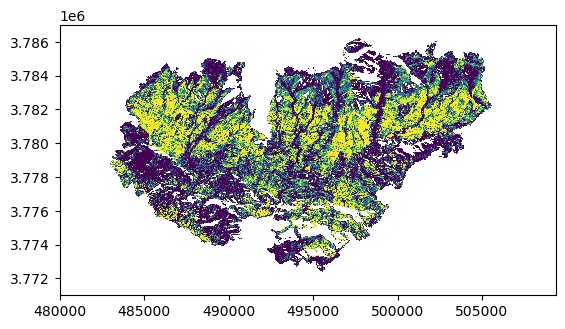

In [144]:
plt.imshow(masked_band_7, vmin=0, vmax=1, interpolation='nearest', extent=[upper_left_x, lower_right_x, lower_right_y, upper_left_y], origin='lower')

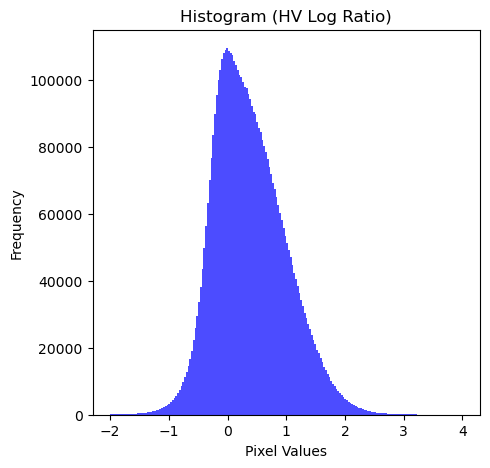

In [145]:
plt.figure(figsize=(5, 5))
plt.hist(masked_band_7.flatten(), range = [-2, 4],bins=200, alpha=0.7, color='blue')
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.title('Histogram (HV Log Ratio)')
plt.show()

### Read in stack & mask urban areas

In [155]:
# Open the 9-band GeoTIFF
with rio.open("/Users/peacock/Downloads/2024_Fire/Line_Fire_Stack.tif") as src:
    # Read all bands into an array
    datastack = src.read()
    profile = src.profile  # Save the profile for any later saving operations

# Extract bands for convenience
band_7 = datastack[6]  # Band 7 (HV-log)
mask_band_9 = datastack[8]  # Band 9 (urban areas)

# Create mask out urban areas
mask = (mask_band_9 == 1) 
has_data = (band_7 != 0) & (band_7 != np.nan)
masked_band_7 = np.where(mask & has_data, np.nan, band_7)

# overwrite the original band 7 in the stack with the masked version
# datastack[6] = masked_band_7

# # save masked stack
# output_path = "Bridge_Fire_Stack_Masked.tif"
# with rio.open(output_path, "w", **profile) as dst:
#     dst.write(datastack)

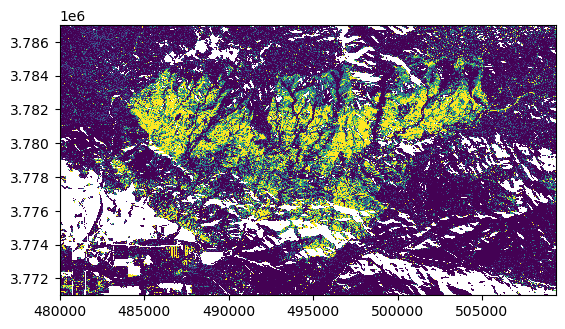

In [156]:
plt.imshow(masked_band_7, vmin=0, vmax=1, interpolation='nearest', extent=[upper_left_x, lower_right_x, lower_right_y, upper_left_y], origin='lower')

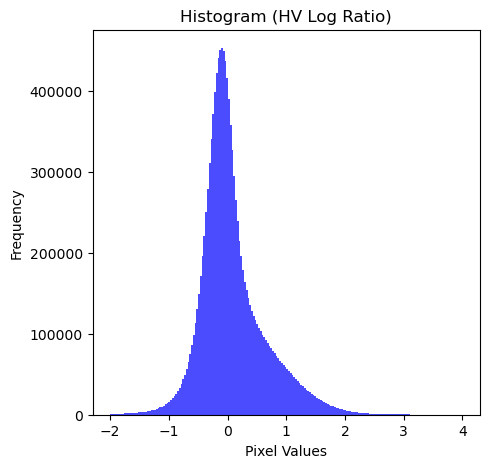

In [157]:
plt.figure(figsize=(5, 5))
plt.hist(masked_band_7.flatten(), range = [-2, 4],bins=200, alpha=0.7, color='blue')
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.title('Histogram (HV Log Ratio)')
plt.show()

Otsu threshold:  -0.4422264


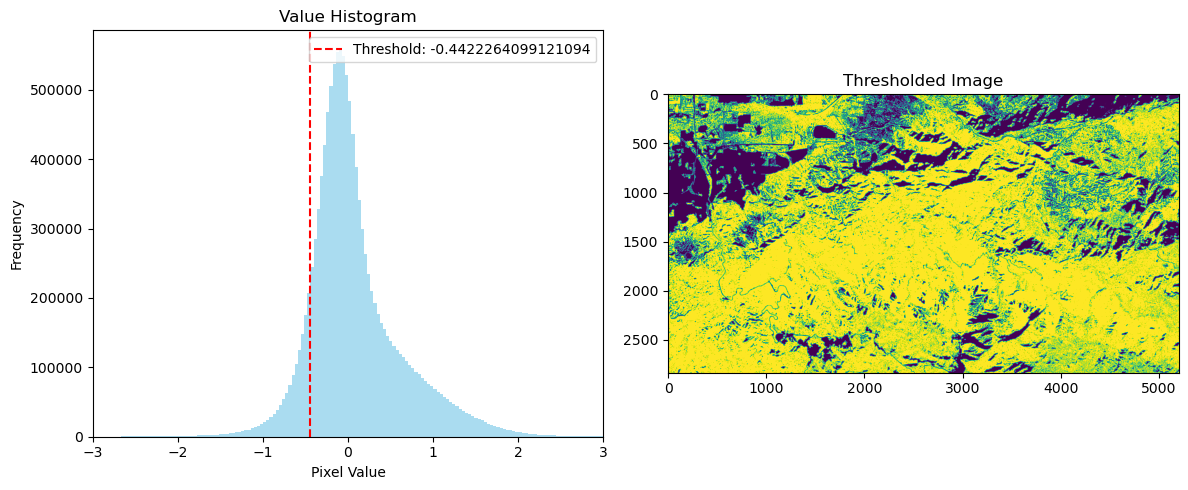

In [158]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters

HV_log = masked_band_7
# Remove NaN values from the array
cleaned_array = HV_log[~np.isnan(HV_log)]
cleaned_array = cleaned_array[np.isfinite(cleaned_array)]

# Perform Otsu's thresholding on the cleaned array
threshold_value = filters.threshold_otsu(cleaned_array)
print('Otsu threshold: ', threshold_value)

threshold_value = 0
print(f"Selected threshold: {threshold_value}")
# Apply the threshold to the original array
thresholded_image = HV_log > threshold_value

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
axes[0].hist(cleaned_array.ravel(), bins=5000, color='skyblue', alpha=0.7)
axes[0].axvline(x=threshold_value, color='red', linestyle='--', label=f'Threshold: {threshold_value}')
axes[0].set_title('Value Histogram')
axes[0].set_xlabel('Pixel Value')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(-3, 3)  # Set x-axis limits
axes[0].legend()

# Plot the thresholded image
axes[1].imshow(thresholded_image, cmap='viridis')
axes[1].set_title('Thresholded Image')

plt.tight_layout()
plt.show()